In [10]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import numpy as np

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# process the reflective measurement results
# in a reflective measurement the data is encoded in the phase of the output signal
def process_reflective_measurement(freqs, values):
    phase_grad = np.gradient(savgol_filter(np.unwrap(np.angle(values)), 3, 2), freqs)
    return (phase_grad-min(phase_grad))/(max(phase_grad)-min(phase_grad)) - 1

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return -a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies 
#and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs, values):
    p0=[freqs[np.argmin(values)], (freqs[-1]-freqs[0])/2, min(values), 0]
    bounds=([freqs[0], 0, -np.inf, -np.inf], [freqs[-1], freqs[-1]-freqs[0], np.inf, np.inf])
    popt, pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt, pcov

# exponential function
def exponential(t, tau, a, offset):
    return a*np.exp(-t/tau)+offset

# fit an exponential function
def fit_exponential(ts, values):
    p0=[np.average(ts), 1, 0]
    return curve_fit(exponential, ts, values, p0=p0)

In [13]:
def fit_lorentzian(freqs, values):
    p0=[freqs[np.argmin(values)], (freqs[-1]-freqs[0])/2, min(values), 0]
    bounds=([freqs[0], 0, -np.inf, -np.inf], [freqs[-1], freqs[-1]-freqs[0], np.inf, np.inf])
    popt, pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt, pcov

In [15]:
list=[0,1,2,3,4,5]
list[-1]

5

In [12]:
import pandas as pd
df=pd.DataFrame(p0)

display(df)


NameError: name 'p0' is not defined

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize
import pandas as pd

# define fitting function
def GaussPolyBase(f,a,b,c,P,fp,fw):
    return a+b*f+c*f*f+P*np.exp(-0.5*((f-fp)/fw/2)**2)
#read in spectrum from data file
#f=frequency, s=signal, ds=s uncertainty
f,s,ds=np.loadtxt("Spectrum.txt",skiprows=4,unpack=True)

df=pd.DataFrame(data=f)


#print(df)
#print(s)
#print(ds)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize
import pandas as pd

# define fitting function
def GaussPolyBase(f,P,fp,fw):
    return P*np.exp(-0.5*((f-fp)/fw/2)**2)
#read in spectrum from data file
#f=frequency, s=signal, ds=s uncertainty
f,s,ds=np.loadtxt("Spectrum.txt",skiprows=4,unpack=True)

df=pd.DataFrame(data=f)


#print(df)
#print(s)
#print(ds)

In [30]:
#initial guesses for fitting parameters
a0,b0,c0=60.,-3.,0.
p0,fp0,fw0=80.,11.,2.

#fit data using Scipy's Levenberg Marquart method
nlfit,nlpcov=scipy.optimize.curve_fit(GaussPolyBase,f,s,p0=[a0,b0,c0,p0,fp0,fw0],sigma=ds)

df=pd.DataFrame(data=nlfit)
print(df)
#print(nlpcov)

#unpack fitting parameters
a,b,c,P,fp,fw=nlfit
da,db,dc,dP,dfp,dfw=[np.sqrt(nlpcov[j,j]) for j in range(nlfit.size)]

#df=pd.DataFrame(data=nlpcov)

#print(df)

           0
0  55.437757
1  -1.767686
2  -0.008518
3  73.156531
4  11.085484
5   0.932621


In [34]:
f_fit=np.linspace(0.0,25.,128)
s_fit=GaussPolyBase(f_fit,a,b,c,P,fp,fw)

resids=s-GaussPolyBase(f,a,b,c,P,fp,fw)
redchisqr=((resids/ds)**2).sum()/float(f.size-6)

#print(f_fit)
print(s_fit)

[ 55.43775875  55.08946029  54.74050277  54.39088705  54.04061458
  53.68968788  53.33811112  52.98589127  52.63303975  52.27957504
  51.92552669  51.57094133  51.21589162  50.86048929  50.50490395
  50.14938964  49.79432183  49.44024801  49.08795564  48.73856168
  48.39362834  48.05530943  47.72653134  47.41121127  47.11451324
  46.84313889  46.6056457   46.41277934  46.27779963  46.21677204
  46.24878842  46.39607302  46.68392442  47.14044102  47.79597931
  48.68230181  49.83138512  51.27388013  53.03724418  55.14359887
  57.60740443  60.43307879  63.61272299  67.1241401   70.92934647
  74.97377     79.18630647  83.48036037  87.75593477  91.90275703
  95.80434119  99.34280141 102.40415246 104.88377165 106.6916608
 107.75714006 108.03263277 107.49625861 106.15303792 104.03461472
 101.19751978  97.72010668  93.69839254  89.24111114  84.46433337
  79.48602435  74.42088874  69.3758093   64.44611537  59.71283511
  55.24099813  51.07897161  47.25874037  43.7969854   40.69677888
  37.949697

<ErrorbarContainer object of 3 artists>

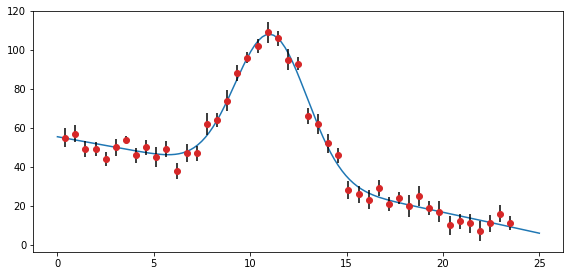

In [12]:
fig=plt.figure(1,figsize=(9.5,6.5))
gs=gridspec.GridSpec(2,1,height_ratios=[6,2])

ax1=fig.add_subplot(gs[0])
ax1.plot(f_fit,s_fit,'-C0')
ax1.errorbar(f,s,yerr=ds,fmt='oC3',ecolor='black')

In [16]:
import tkinter

In [24]:
window=tkinter.Tk()
window.title("Name")
window.geometry("1024x720+100+100")
window.resizable(True,True)

window.mainloop()

In [25]:
def select(self):
    value="값 : "+str(scale.get())
    label.config(text=value)

var=tkinter.IntVar()

scale=tkinter.Scale(window, variable=var, command=select, orient="horizontal", showvalue=False, tickinterval=50, to=500, length=300)
scale.pack()

label=tkinter.Label(window, text="값 : 0")
label.pack()

window.mainloop()

RuntimeError: Too early to create variable: no default root window

In [24]:
def func(x,a,b):
    return a*x+b

x=np.linspace(0,100)
y=func(x,1,2)

yn=y+0.98*np.random.normal(size=len(x))

for i in range(10):
    popt, pcov=curve_fit(func,x,yn)
    print(popt)

[0.99741122 2.29652892]
[0.99741122 2.29652892]
[0.99741122 2.29652892]
[0.99741122 2.29652892]
[0.99741122 2.29652892]
[0.99741122 2.29652892]
[0.99741122 2.29652892]
[0.99741122 2.29652892]
[0.99741122 2.29652892]
[0.99741122 2.29652892]
